#Data Ingestion

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession

# Initialize a Spark session
spark = SparkSession.builder \
    .appName("Project-3: Crypto Prediction") \
    .getOrCreate()

In [ ]:
# download the data
!gdown 1_WwoqggSBvQEt7IfVRC3ZW0zxT0rzsU5

Downloading...
From: https://drive.google.com/uc?id=1_WwoqggSBvQEt7IfVRC3ZW0zxT0rzsU5
To: /content/train.csv
100% 1.43M/1.43M [00:00<00:00, 16.9MB/s]


In [ ]:
# Import required functions and types
from pyspark.sql.utils import AnalysisException
import pyspark.sql.functions as F
import pyspark.sql.types as T
from functools import reduce

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load the data into a Spark DataFrame
data_path = '/content/train.csv'
df = spark.read.csv(data_path, header=True, inferSchema=True)
df.show(n=5)

+---+-------------+-------------+-------------+------------+------------+------------+------------+-----------+-----------+-------------------+-------------------+------------------+-----------+-----------+-----------+-----------+------------------+------------------+------------------+-----------+-----------+-----------+-----------+------------------+-------------------+------------------+-----------+-----------+-----------+-----------+------------------+------------------+-----------+-----------+-----------+-----------+------------------+-------------------+------------------+-----------+-----------+-----------+-----------+-------------------+------------------+------------------+-----------+-----------+-----------+-----------+-------------------+-------------------+------------------+-----------+-----------+-----------+-----------+------------------+-------------------+------------------+-----------+-----------+-----------+-----------+------------------+-------------------+---------

In [ ]:
#print shape of Pyspark Dataframe
print("Number of rows:",df.count())
print("Number of columns:",len(df.columns))

Number of rows: 2660
Number of columns: 78


In [ ]:
# Print the schema
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- TR_1_EventInd: double (nullable = true)
 |-- TR_2_EventInd: double (nullable = true)
 |-- TR_3_EventInd: double (nullable = true)
 |-- feature_10_A: double (nullable = true)
 |-- feature_10_B: double (nullable = true)
 |-- feature_10_F: double (nullable = true)
 |-- feature_10_G: double (nullable = true)
 |-- feature_1_A: double (nullable = true)
 |-- feature_1_B: double (nullable = true)
 |-- feature_1_C: double (nullable = true)
 |-- feature_1_D: double (nullable = true)
 |-- feature_1_E: double (nullable = true)
 |-- feature_1_F: double (nullable = true)
 |-- feature_1_G: double (nullable = true)
 |-- feature_2_A: double (nullable = true)
 |-- feature_2_B: double (nullable = true)
 |-- feature_2_C: double (nullable = true)
 |-- feature_2_D: double (nullable = true)
 |-- feature_2_E: double (nullable = true)
 |-- feature_2_F: double (nullable = true)
 |-- feature_2_G: double (nullable = true)
 |-- feature_3_A: double (nullable = true)
 |--

The given dataset has 2660 records and 78 columns where the columns mean:

**ID:** ID of each data point (do not include in your model)

**Target:** 0 - the price dropped 2 weeks after the time of prediction 1 - the price increased 2 weeks after the time of prediction. This the target variable

**feature_x_y:** independent variables from the market data.

**TR_x_EventInd:** Event that may of may not affect the crypto currencies price.

**index_1 ~ index_3:** the search trend on specific keywords pretaining to crypto currencies.

The schema of this dataset indicates that all the columns are double type except 'ID' and 'Target'(both are integer type). Our initial focus will involve Exploratory Data Analysis (EDA) to uncover insights from data and evaluate the correctness of data types through visualizations. Specifically, we'll examine distributions, correlations, and other patterns within the dataset to ensure its integrity and relevance for subsequent analysis.

# **1. Exploratory Data Analysis**

In [ ]:
# Convert Spark DataFrame to Pandas for plotting
df_pd = df.toPandas()

### **Plot1 - Box plot between market features and target**

We aimed to analyze the distribution patterns of various features and their relationship with cryptocurrency price movements.

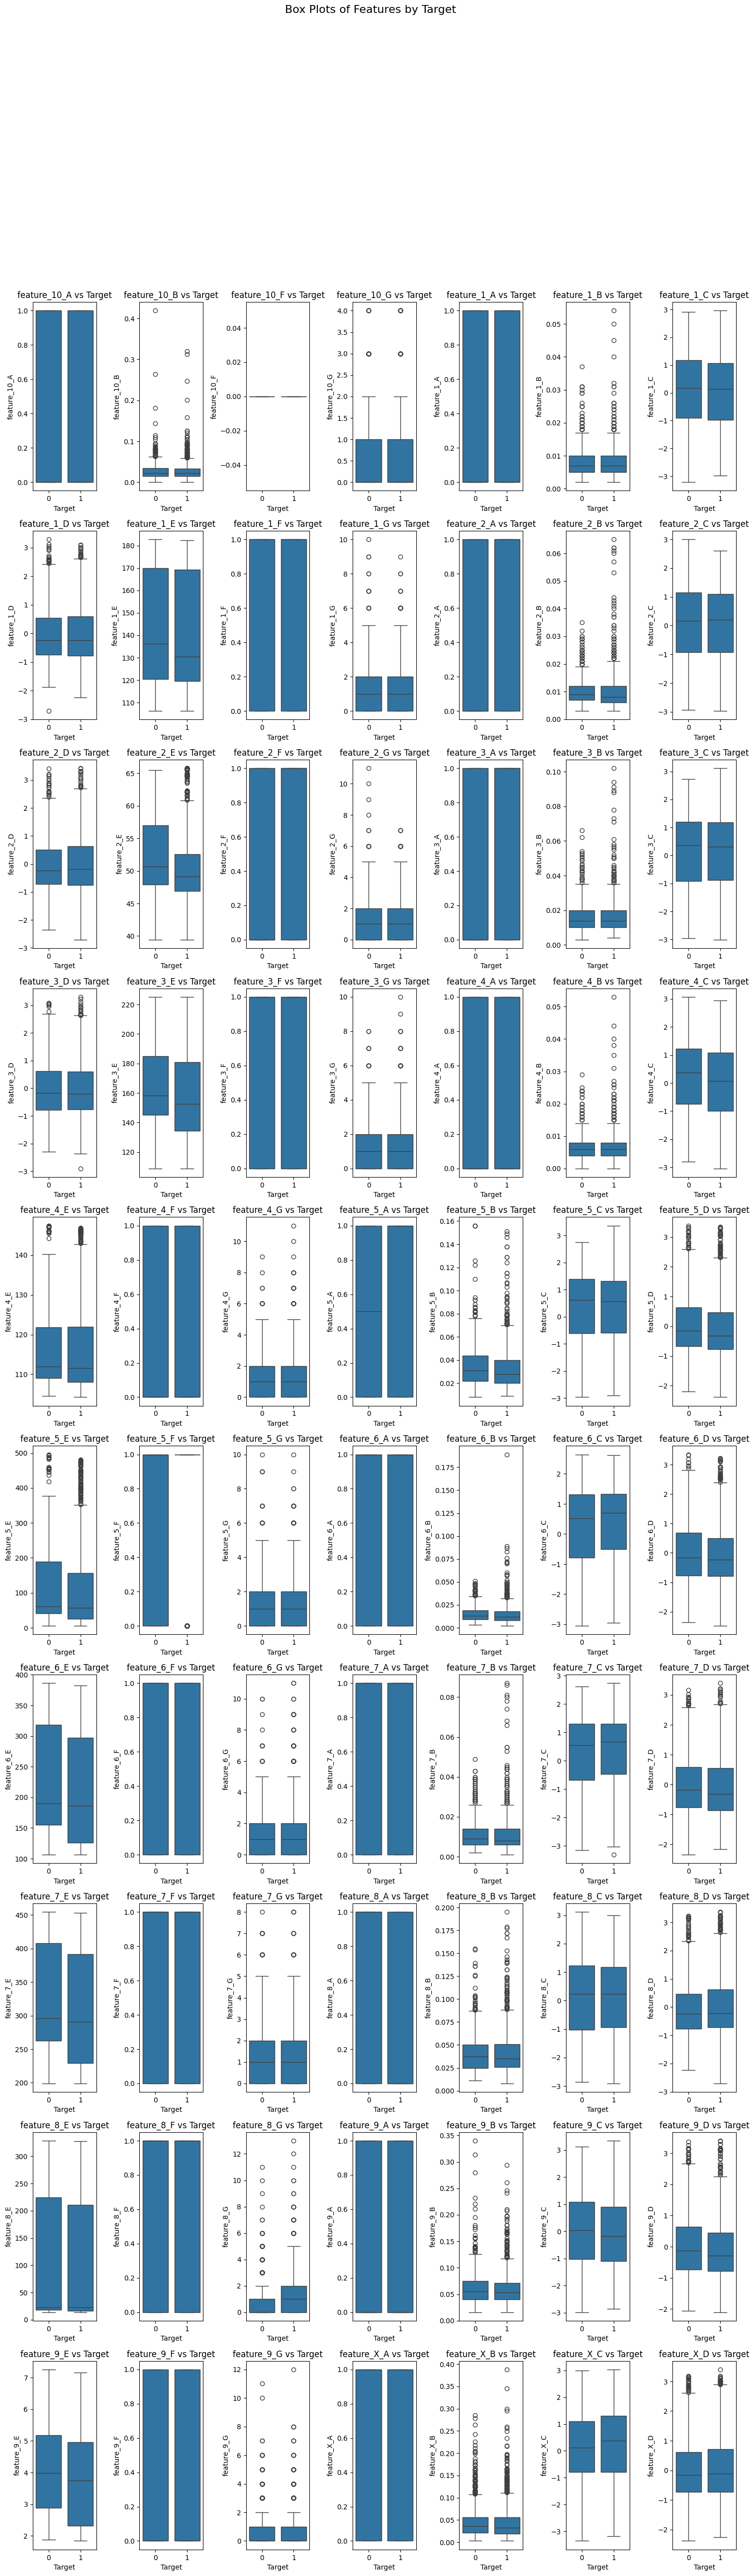

In [ ]:
import numpy as np
# Selecting all features starting with 'feature_'
feature_cols = [col for col in df_pd.columns if col.startswith('feature_')]
target_variable = 'Target'

# Determine the number of rows and columns for the subplot grid
num_rows = (len(feature_cols) + 1) // 2  # Add 1 to round up
num_cols = 7

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
fig.suptitle(f'Box Plots of Features by {target_variable}', fontsize=16)

# Flatten the axes array
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

# Iterate through each feature and create a box plot
for i, feature_col in enumerate(feature_cols):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(data=df_pd, x=target_variable, y=feature_col, ax=axes[row, col])
    axes[row, col].set_title(f'{feature_col} vs {target_variable}')
    axes[row, col].set_xlabel(target_variable)
    axes[row, col].set_ylabel(feature_col)

# Hide any unused subplots
for i in range(len(feature_cols), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Observing the boxplots for similarities across different features we noticed below mentioned points:


*   We notice that some distributions are quite consistent across both targets,
suggesting limited differentiation power for predicting price movement. Specifically, feature_1_G, feature_2_G, feature_3_G, and similarly labeled "G" features across the dataset show a narrow range of values with a large number of outliers. This pattern could indicate that these "G" features represent some common attribute or measurement that is not significantly affected by the fluctuations in cryptocurrency prices.
*   Additionally, the "F" features like feature_1_F through feature_9_F exhibit almost identical tall bar distributions at value 1, indicating these might be binary indicators that are consistently present in both price increase and decrease scenarios.




*   In terms of impact, some features show a distinct difference in distribution between Target 0 and Target 1, suggesting a stronger relationship with the price movement. For instance, feature_3_A and feature_6_A display a noticeable shift in their medians depending on the target value, indicating these features may be influential in predicting price increases
*   Similarly, continuous features with a wider interquartile range, such as feature_2_E and feature_3_E, have numerous outliers and broad distributions, which suggests high variability that could be significant in forecasting price direction. The differences in the spread and central tendencies (medians) for these features across the target variable hint at their potential utility in a predictive model for the cryptocurrency market.



.

### **Plot2 - Combined distribution of target by Event type**


We aimed to analyze how often different TR_x_EventInd events happen and if they usually lead to changes in cryptocurrency prices.

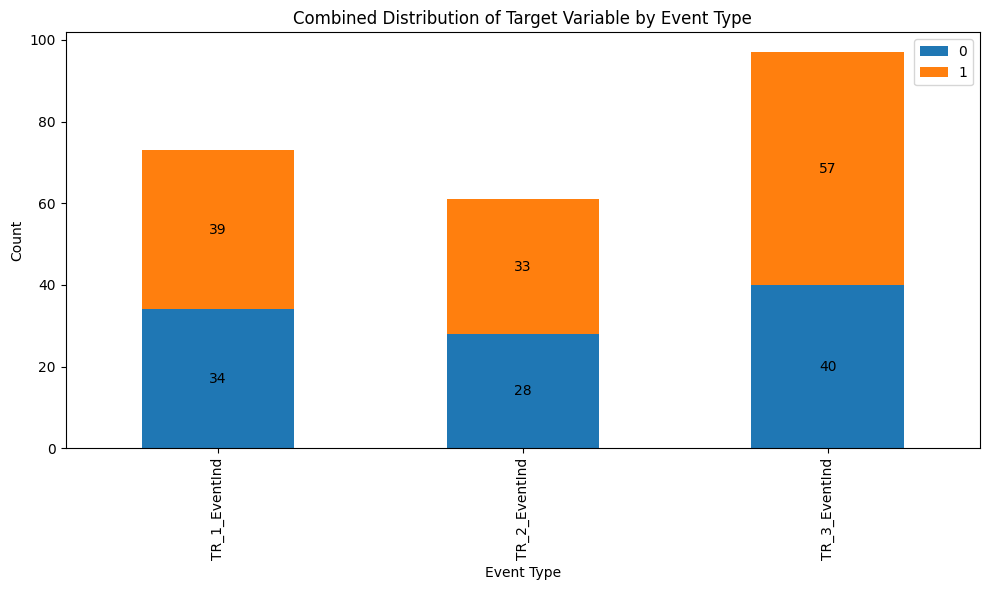

In [ ]:
# Get the count of target occurences by event type if event occured (i.e, eventInd == 1)
event1_df = df.filter(df['TR_1_EventInd'] == 1).groupby('Target').count()
event2_df = df.filter(df['TR_2_EventInd'] == 1).groupby('Target').count()
event3_df = df.filter(df['TR_3_EventInd'] == 1).groupby('Target').count()

# First, collect the data from Spark to Python
event1_counts = event1_df.toPandas().set_index('Target')['count'].to_dict()
event2_counts = event2_df.toPandas().set_index('Target')['count'].to_dict()
event3_counts = event3_df.toPandas().set_index('Target')['count'].to_dict()

# Create a dictionary to prepare the combined data
combined_counts = {
    'Event Type': ['TR_1_EventInd', 'TR_2_EventInd', 'TR_3_EventInd'],
    '0': [
        event1_counts.get(0, 0),  # Default to 0 if there is no count
        event2_counts.get(0, 0),
        event3_counts.get(0, 0)
    ],
    '1': [
        event1_counts.get(1, 0),  # Default to 0 if there is no count
        event2_counts.get(1, 0),
        event3_counts.get(1, 0)
    ]
}

# Convert the combined data into a pandas DataFrame
combined_df = pd.DataFrame(combined_counts)
combined_df.set_index('Event Type', inplace=True)

# Now plot using Matplotlib
ax = combined_df.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], figsize=(10, 6))

# Set the labels and title
ax.set_xlabel('Event Type')
ax.set_ylabel('Count')
ax.set_title('Combined Distribution of Target Variable by Event Type')

# Annotate the bar with its count value
for container in ax.containers:
    ax.bar_label(container, label_type='center')

# Show the plot
plt.tight_layout()
plt.show()






The plot suggest that across all three event types, the occurrence where the target variable is 1, indicating that the price has risen after two weeks, is more prevalent than where the target variable is 0, where there is no price increase. This pattern is consistent across the board. Particularly noteworthy is the TR_3_EventInd event type, which exhibits a more substantial gap between the occurrences of the target variable's outcomes, suggesting it has a more pronounced effect on influencing price movements.Additionally, in a comparison of the frequency of events, the TR_3_EventInd stands out as the most frequently occurring event, with the highest aggregate number of occurrences and the largest number of instances resulting in a price increase (target variable 1), This indicates that there is more probability for price increase after 2 weeks if event 3 occurs. On the opposite end, the TR_2_EventInd represents the least frequent event, with the smallest overall number of occurrences and the fewest instances of both a price increase and no price increase (target variable 1 and 0, respectively). This analysis points to TR_3_EventInd as being the most significant in terms of occurrence and impact on prices after a two-week period.






### **Plot3 - Uncovering search trend analysis using index data**


We aimed to examine the relationship between search trends (index_1 to index_3) and cryptocurrency price changes, aiming to uncover whether certain search keywords are consistently associated with price movements.

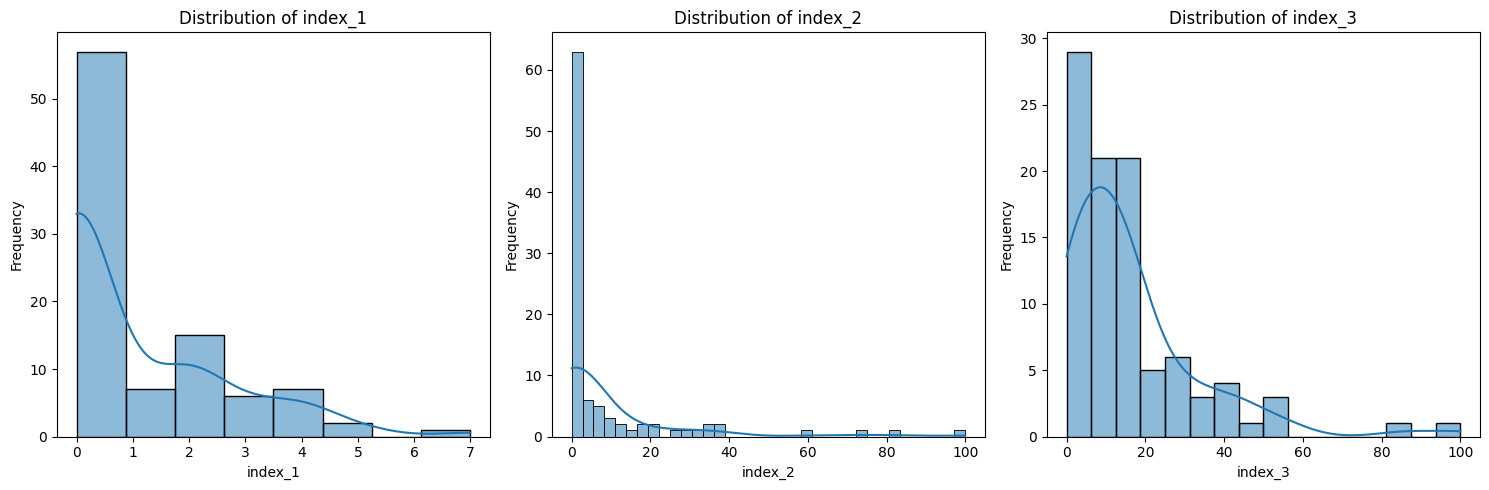

In [ ]:
# Visualize the distribution of search trends
# Collect the data for plotting to the driver node (convert to Pandas DataFrame)
pd_df = df.select('index_1', 'index_2', 'index_3').toPandas()

# Plot the distribution of each index
plt.figure(figsize=(15, 5))

for i, column in enumerate(['index_1', 'index_2', 'index_3'], 1):
    plt.subplot(1, 3, i)
    sns.histplot(pd_df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

From the histograms we can depict:

1. **Distribution of index_1:** This histogram shows that index_1 is heavily skewed towards the lower values, with a sharp peak at the lowest value bin and a rapid decline as the index value increases. This suggests that most of the data points for index_1 are clustered around the lower end of the scale, indicating that whatever the index_1 is tracking, it tends to have lower values in the dataset.

2. **Distribution of index_2:** The distribution of index_2 also shows a skew towards lower values but with a longer tail extending towards higher values. The peak is at a lower value, similar to index_1, but there's a noticeable presence of values spread out across the range, up to 100. This may imply that while most of the activity related to index_2 is also on the lower end, there are occurrences of much higher values, which might correspond to spikes or bursts in whatever is being tracked by index_2.

3. **Distribution of index_3**: The histogram for index_3 presents a somewhat bi-modal distribution with a primary peak at the lowest value bin and a secondary, lower peak around the value of 20. Following the second peak, the frequency tapers off with the index value increase, with a few occurrences of higher values. The bi-modal nature suggests that there are two common states in the data related to index_3, possibly representing two distinct modes of behavior or outcomes that are being tracked.

For all three indices, the distributions suggest that most of the data points represent lower levels of whatever is being measured (such as search interest or activity), with infrequent occurrences of very high levels.


###**Plot4 - Correlation Between Search trends and Target**

We aimed to analyze the potential correlation between search trends (index_1 ~ index_3) and cryptocurrency price changes. Specifically, we investigated whether certain search keywords correlate with price increases or decreases.

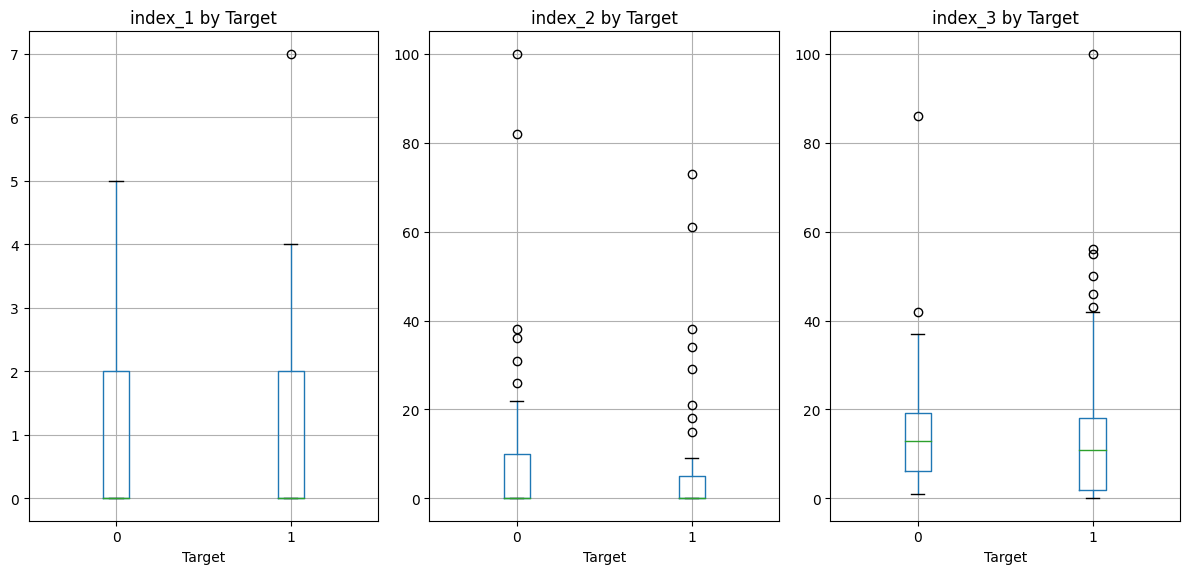

In [ ]:
# Collect data to the driver as Pandas DataFrame for visualization
pd_df = df.select('Target', 'index_1', 'index_2', 'index_3').toPandas()

# Now plot using Matplotlib to create box plots for each index
plt.figure(figsize=(12, 6))

# Create a boxplot for each search trend index
for i, column in enumerate(['index_1', 'index_2', 'index_3'], 1):
    plt.subplot(1, 3, i)
    pd_df.boxplot(column=column, by='Target', ax=plt.gca())
    plt.title(f'{column} by Target')
    plt.suptitle('')  # Suppress the default title to prevent it from overlapping with the subplot titles

# Display the plot
plt.tight_layout()
plt.show()


From the box plots we can infer that:

1. index_1 by Target: The medians for index_1 appear to be the same or very close for both Target 0 and Target 1. There is also a similar range of values (IQR) for both categories, and a small number of outliers. This suggests that the distribution of index_1 is similar regardless of whether the Target is 0 or 1, which means index_1 might not be a strong predictor for the Target on its own.

2. index_2 by Target: The distribution of index_2 seems to show a higher median and a wider range for Target 0 compared to Target 1, although there are outliers on both. This may suggest that higher values of index_2 could be associated with a decrease in the cryptocurrency price (Target 0), but it's important to note the significant overlap in the interquartile ranges and numerous outliers.

3. index_3 by Target: Similar to index_2, index_3 shows a slightly higher median for Target 0, but the difference is less pronounced than index_2. The IQR for Target 0 is wider, indicating more variability when the price decreases. Again, there are several outliers in both categories.


4. Combining insights from both the histograms and the box plots, it seems index_2 and possibly index_3 may have some relationship with the Target variable, as their distributions change somewhat between the two Target categories. index_1 appears to have a similar distribution for both Target categories, suggesting a weaker relationship.

### **Plot5 - Distribution of target variable**


We would like to examine the distribution of the target variable in the dataset to gain insight into which metrics should be prioritized for evaluating models and to determine appropriate measures to address potential imbalance issues during model training.

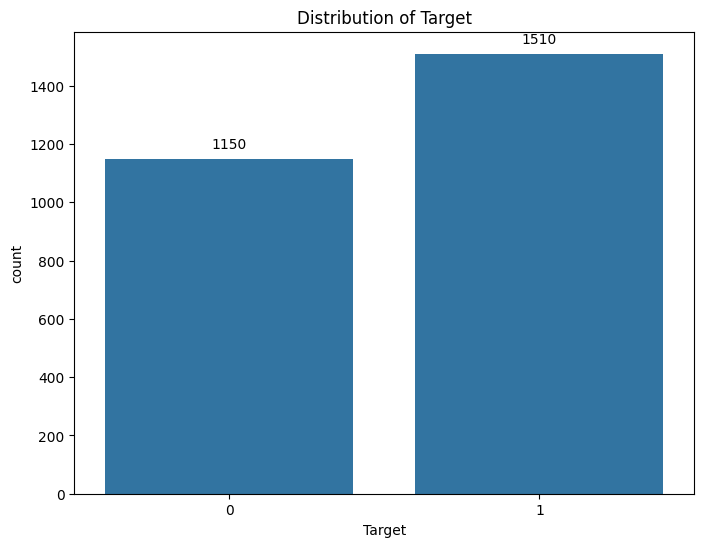

In [ ]:
# Set the figure size for the plot
plt.figure(figsize=(8, 6))

# Create a countplot using seaborn, with 'Target' on the x-axis
ax = sns.countplot(data=df_pd, x='Target')

# Set the title of the plot
plt.title('Distribution of Target')

# Add counts above the bars
for p in ax.patches:
    # Annotate each bar with its count value
    ax.annotate(format(p.get_height(), '.0f'),  # Format the count to display without decimals
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the annotation at the center of each bar
                ha='center', va='center',  # Center the annotation horizontally and vertically
                xytext=(0, 10),  # Offset the text above the bar by (0, 10) points
                textcoords='offset points')

# Show the plot
plt.show()

The plot reveals that there are more instances where the cryptocurrency price increased (class 1) compared to instances where it decreased (class 0). This suggests a slight imbalance in the dataset. In real-world terms, this means there were more times when the cryptocurrency's value went up than when it went down during the observed period.

This imbalance could affect how a predictive model trained on this data performs. For example, the model might lean towards predicting price increases more often since they are more common in the dataset. When evaluating such a model, metrics like accuracy alone might not provide the full picture. Metrics that consider the class distribution, such as F1-score or precision-recall, could give a better understanding of the model's effectiveness. So, while evaluating our models we decided to give more weightage to F1 scores to choose our best model.

**EDA Conclusion:** The exploratory data analysis (EDA) sheds light on several crucial insights regarding the relationship between various features and cryptocurrency price movements. Firstly, certain features exhibit consistent distributions across both target categories, indicating limited predictive power solely based on these attributes. Notably, features like "G" and "F" show narrow ranges with numerous outliers, suggesting a common attribute or measurement not significantly influenced by price fluctuations. However, other features, such as feature_3_A and feature_6_A, demonstrate distinct differences in distribution between target categories, hinting at a stronger association with price movements. Moreover, continuous features with wider interquartile ranges display significant variability, potentially offering valuable insights for forecasting price direction. Additionally, the analysis of search trends indicates a potential correlation between certain search keywords and price changes, particularly with variations observed in index_2 and index_3 distributions between target categories. Furthermore, the dataset's imbalance, with more instances of price increases than decreases, underscores the need for careful consideration of evaluation metrics like F1-score to ensure robust model assessment. Overall, these findings underscore the complexity of cryptocurrency price dynamics and emphasize the importance of comprehensive analysis in developing effective predictive models.

# **2. Prepare Data for Modeling**

Initially the dataset was divided into two distinct sets : a training set(train_df) and test set(test_df). This division was made by reserving the last 400 rows for the test set and the remaining 2260 rows for the training set. Then we extracted the ID column as Identifiers and Target as Target_Column.

In [ ]:
IDENTIFIERS = ["ID"]
print(IDENTIFIERS)

['ID']


In [ ]:
TARGET_COLUMN = ["Target"]
print(TARGET_COLUMN)

['Target']


In [ ]:
# split the dataset into train set of 2260 rows
train_df = df.limit(2260)
train_df.count()

2260

In [ ]:
# split the dataset into test set of 400 rows
test_df = df.subtract(train_df)
test_df.count( )

400

#### Handling Missing Values

*   One of the initial steps in the preprocessing phase involved a comprehensive analysis to identify missing values within the dataset.
*   We extracted the missing value count for all the columns and found that six (6) variables had approximately 50%, or more, missing values and we decided not to use those columns in our model.
*   The 6 variables that we eliminated are 'TR_1_EventInd','TR_2_EventInd','TR_3_EventInd','index_1','index_2','index_3'.
*   Next, we extracted a list of variables that are not identifiers,Target and not having high missing values.

Note: Though it is proved from ED(plot2 & plot3) that there might be significant impact of TR_x_EventInd and index_x variables on the target, we decided to eliminate them as they contain a lot of missing values

In [ ]:
 #Define a function to count nulls and nans in each column and return as vertical format
def count_nulls_nans_vertical(df):
    # Create an array of StructType with column names and counts
    cols_counts = [F.struct(F.lit(c).alias("Column"), F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias("Missing_Count")) for c in df.columns]
    # Aggregate these structs into a single array column
    array_col = F.array(*cols_counts)
    # Explode the array to create a row for each struct
    df_long = df.select(F.explode(array_col).alias("data")).select("data.*")
    # Sort by Missing_Count in descending order0
    df_sorted = df_long.orderBy(F.col("Missing_Count").desc())
    return df_sorted

# Use the function and show the results
missing_data_vertical = count_nulls_nans_vertical(train_df)
missing_data_vertical.show()

+-------------+-------------+
|       Column|Missing_Count|
+-------------+-------------+
|TR_2_EventInd|         2207|
|TR_1_EventInd|         2196|
|      index_1|         2180|
|      index_2|         2180|
|      index_3|         2180|
|TR_3_EventInd|         2172|
|  feature_4_E|          976|
|  feature_1_E|          781|
|  feature_2_E|          781|
|  feature_3_E|          781|
|  feature_5_E|          781|
|  feature_6_E|          781|
|  feature_7_E|          781|
|  feature_8_E|          781|
|  feature_9_E|          781|
|  feature_1_C|          702|
|  feature_1_D|          702|
|  feature_2_C|          702|
|  feature_2_D|          702|
|  feature_3_C|          702|
+-------------+-------------+
only showing top 20 rows



In [ ]:
total_rows = train_df.count()
# Calculate missing values and filter columns with > 50% missing data
missing_data_vertical = count_nulls_nans_vertical(train_df)
high_missing_columns = missing_data_vertical.filter((F.col("Missing_Count") / total_rows) > 0.5).select("Column").rdd.flatMap(lambda x: x).collect()

print(len(high_missing_columns))

6


In [ ]:
# Update CONTINUOUS_COLUMNS to exclude these high-missing columns as well as any identifiers/targets
CONTINUOUS_COLUMNS = [
    x
    for x in train_df.columns
    if  x not in IDENTIFIERS and x not in high_missing_columns and x not in TARGET_COLUMN
]

print(len(CONTINUOUS_COLUMNS))

70


In our dataset analysis, we discovered distinct patterns between variables(from plot1 and summary statistics).


*   Specifically, variables ending in '_A', '_F', and '_G' were found to contain binary and integer values. Variables with the suffixes '_A' and '_F' exclusively held binary values (0s and 1s), whereas those ending in '_G' included integer values ranging from 0 to 10.
*   Conversely, variables with the suffixes '_B', '_C', '_D', and '_E' consisted of numerical data characterized by decimal values.

So, we categorized the variables into two groups to streamline further analysis and modeling:


*   **Categorical Columns:** This category includes variables ending in '_A', '_F', and '_G', which are primarily composed of binary(0 and 1) and nominal values(integer type data with multiple categories like 0,2,3,4,8 etc).

*   **Continuous Columns:** This category encompasses variables ending in '_B', '_C', '_D', and '_E', all of which contain numerical (decimal) data.

Note : Though the data type of the above considered categorical columns is double,we just approached the variables in the same way how we deal with categorical variables without converting them to binary(i.e, we left their data type as it is)

In [ ]:
# summary statistics
train_df.select(*CONTINUOUS_COLUMNS).summary(
"mean",
"stddev",
"min",
"25%",
"50%",
"75%",
"max",
).show()

+-------+-------------------+--------------------+------------+------------------+------------------+--------------------+-------------------+-------------------+------------------+-------------------+------------------+------------------+--------------------+-------------------+--------------------+-----------------+------------------+------------------+------------------+--------------------+-------------------+--------------------+------------------+------------------+------------------+-------------------+--------------------+------------------+------------------+-------------------+------------------+------------------+--------------------+-------------------+--------------------+------------------+-------------------+-----------------+------------------+--------------------+-------------------+--------------------+------------------+------------------+------------------+-------------------+--------------------+------------------+--------------------+------------------+-----------

In [ ]:
# Features ending with 'A,F,G' are categorical with double datatype
categorical_columns = [col for col in CONTINUOUS_COLUMNS if col.endswith(('_A', '_F', '_G'))]

# Features ending with 'B,C,D,E' are continuous with double datatype
continuous_columns = [col for col in CONTINUOUS_COLUMNS if not col.endswith(('_A', '_F', '_G'))]

####**Methodology**

Understanding that our approach(categorizing) might yield variable outcomes or not,so we've adopted two distinct methods:

*   **Method 1:** Treating all variables uniformly as continuous columns, regardless of their categorical or continuous nature.
*   **Method 2:** Segregating variables into two categories based on their intrinsic characteristics, distinguishing between categorical and continuous columns.

By employing these dual methodologies, we aim to thoroughly explore the nuances of our dataset and optimize our modeling approach.

**Stage-1 : Imputing Missing Values**

#####Method 1: Imputing missing values with mean

*   To address missing values in all the used columns, we followed 'mean' strategy approach. This approach calculates the mean of each specified column and uses these mean values to replace any missing entries.

#####Method 2 :Imputing missing values with mean and mode

*   To fill missing values in continuous columns, we used 'mean' values to replace any missing entries.
*   To fill missing entries in categorical columns, we followed 'mode' strategy method. This method identifies the most frequently occurring value (the mode) in each column and replaces missing values with this mode.

In [ ]:
from pyspark.ml.feature import Imputer, VectorAssembler, StandardScaler

In [ ]:
#Stage1

#Method-1
theOutputCols = [c+'_i' for c in CONTINUOUS_COLUMNS]

imputer = MF.Imputer(
      inputCols=CONTINUOUS_COLUMNS,
      outputCols=theOutputCols,
      strategy="mean"
)

#Method-2
continuous_imputer = Imputer(inputCols=continuous_columns, outputCols=[f"{c}_imputed" for c in continuous_columns], strategy="mean")
cat_imputer = Imputer(inputCols=categorical_columns, outputCols=[f"{c}_mode_imputed" for c in categorical_columns], strategy="mode")

**Stage-2 : Vector Assembler**


*   To consolidate preprocessed data columns into a single feature vector,we used VectorAssembler that combines specified input columns into one output column named "features".
*   This column contains vector representations of the original data, which are more suitable for use in machine learning models.

In [ ]:
#stage-2

#Method-1
continuous_assembler = MF.VectorAssembler(
    inputCols=theOutputCols,
    outputCol="continuous"
)

#Method-2
assembler = VectorAssembler(inputCols=[f"{c}_imputed" for c in continuous_columns] + [f"{c}_mode_imputed" for c in categorical_columns], outputCol="features")

**Stage-3 : Transformation**

*   To scale the feature vectors created by the VectorAssembler such that they have a mean of zero and a variance of one, we standardized all the variables using Standard Scalar
*   The StandardScaler achieves this by computing the mean and standard deviation for each feature in the input column. It then uses these values to transform the data into a scale where the variance is balanced and the mean centers around zero.

The formula for standard scalar is

\begin{equation}
\text{Standard Scalar} = \frac{x - \text{mean}(x)}{\text{standard deviation}(x)}
\end{equation}

In [ ]:
#stage-3

#Method-1
continuous_scaler = MF.StandardScaler(
    inputCol="continuous",
    outputCol="continuous_scaled",
    withMean=True,
    withStd=True
)

#Method-2
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# **3. Models**

Utilizing above stages, we designed pipelines and developed models. Initially we developed Baseline model and then for all other models, We considered grid search method in order to identify models with high F1 scores.

###**Baseline Model**

In [ ]:
from pyspark.ml import Pipeline
import pyspark.ml.feature as MF
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assuming 'target_column_name' is the actual name of your target column
Base_clf = RandomForestClassifier(
    featuresCol="continuous_scaled",  # corrected to use the output from the scaler
    labelCol="Target",     # correct this name as per your DataFrame
    seed=42                            # use the same random_state concept as seed here
)

# Setting up the pipeline
my_pipeline = Pipeline(
    stages=[
        imputer,
        continuous_assembler,
        continuous_scaler,
        Base_clf  # Classifier added directly to the pipeline
    ]
)

# Fit the pipeline model
Base_pipeline_model = my_pipeline.fit(train_df)  # train_df should be correctly prepared and passed here

predictions_Base = Base_pipeline_model.transform(test_df)


# Create an evaluator for the classifier
evaluator = MulticlassClassificationEvaluator(
    labelCol="Target",  # Assuming 'Target' is the name of your target column
    predictionCol="prediction",
    metricName="accuracy"  # Change metricName to "f1" for F1 Score
)

# Compute F1 Score on the test set
evaluator.setMetricName("f1")
f1_score = evaluator.evaluate(predictions_Base)
print("F1 Score =", f1_score)

F1 Score = 0.6193837736741405


### **Method-1 : Models with mean imputation**

In [ ]:
# import required modules
from pyspark.ml import Pipeline
import pyspark.ml.feature as MF
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col

####DecisionTree Classifier

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

# DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(
    featuresCol="continuous_scaled",
    labelCol="Target",  # Make sure this is the correct label column for your dataset
    seed=42
)

# Setup the pipeline with all stages
pipeline_dt1 = Pipeline(
    stages=[
        imputer,
        continuous_assembler,
        continuous_scaler,
        dt_clf
    ]
)

# Setup the parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(dt_clf.maxDepth, [5, 10, 20])
             .addGrid(dt_clf.minInstancesPerNode, [1, 2, 4])
             .build())

# Setup the evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="Target",
    predictionCol="prediction",
    metricName="f1"
)

# Setup the cross-validator
crossval = CrossValidator(
    estimator=pipeline_dt1,  # Use the entire pipeline
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5  # 5-fold cross-validation
)

# Perform cross-validation to find the best model
cvModel_dt1 = crossval.fit(train_df)

# Fetch the best model
bestModel_dt1 = cvModel_dt1.bestModel

# Use the best model to make predictions on the test set
predictions_dt1 = bestModel_dt1.transform(test_df)

# Evaluate the best model on the test set
f1_score_dt1 = evaluator.evaluate(predictions_dt1)
print(f"F1 Score: {f1_score_dt1}")

F1 Score: 0.6596497980533242


####RandomForest Classifier

In [ ]:
 # Import RandomForestClassifier
from pyspark.ml.classification import RandomForestClassifier

# RandomForestClassifier
rf_clf = RandomForestClassifier(
    featuresCol="continuous_scaled",
    labelCol="Target",
    seed=42,
    numTrees=10,  # Set the number of trees in the forest
    maxDepth=5   # Set the maximum depth of each tree
)

# Setup the pipeline with all stages
pipeline_rf1 = Pipeline(
    stages=[
        imputer,
        continuous_assembler,
        continuous_scaler,
        rf_clf
    ]
)

# Setup the parameter grid for RandomForest
paramGrid = (ParamGridBuilder()
             .addGrid(rf_clf.numTrees, [10, 20, 30])  # Different numbers of trees
             .addGrid(rf_clf.maxDepth, [5, 10, 15])  # Different tree depths
             .build())

# Setup the evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="Target",
    predictionCol="prediction",
    metricName="f1"
)

# Setup the cross-validator
crossval = CrossValidator(
    estimator=pipeline_rf1,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5  # Using 5-fold cross-validation
)

# Perform cross-validation to find the best model
cvModel_rf1 = crossval.fit(train_df)

# Fetch the best model
bestModel_rf1 = cvModel_rf1.bestModel

# Use the best model to make predictions on the test set
predictions_rf1 = bestModel_rf1.transform(test_df)

# Evaluate the best model on the test set
f1_score_rf1 = evaluator.evaluate(predictions_rf1)
print(f"F1 Score: {f1_score_rf1}")

F1 Score: 0.6826923076923077


####GBT Classifier

In [ ]:
# Import GBTClassifier
from pyspark.ml.classification import GBTClassifier

# Gradient Boosting Classifier
gbt_clf = GBTClassifier(
    featuresCol="continuous_scaled",
    labelCol="Target",
    seed=42,
    maxIter=10,  # Number of iterations (trees)
    maxDepth=5   # Maximum depth of each tree
)

# Setup the pipeline with all stages
pipeline_gbt1 = Pipeline(
    stages=[
        imputer,
        continuous_assembler,
        continuous_scaler,
        gbt_clf
    ]
)

# Setup the parameter grid for Gradient Boosting
paramGrid = (ParamGridBuilder()
             .addGrid(gbt_clf.maxDepth, [5, 10, 15])  # Different tree depths
             .addGrid(gbt_clf.maxIter, [10, 20, 30])  # Different numbers of iterations
             .build())

# Setup the evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="Target",
    predictionCol="prediction",
    metricName="f1"
)

# Setup the cross-validator
crossval = CrossValidator(
    estimator=pipeline_gbt1,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5  # Using 5-fold cross-validation
)

# Perform cross-validation to find the best model
cvModel_gbt1 = crossval.fit(train_df)

# Fetch the best model
bestModel_gbt1 = cvModel_gbt1.bestModel

# Use the best model to make predictions on the test set
predictions_gbt1 = bestModel_gbt1.transform(test_df)

# Evaluate the best model on the test set
f1_score_gbt1 = evaluator.evaluate(predictions_gbt1)
print(f"F1 Score: {f1_score_gbt1}")

Best F1 Score: 0.6552738336713996


### **Method - 2 : Models with mean & mode imputation**

As mentioned in the preparing data for modeling section, we categorized the columns into continuous and categorical and then use them for modeling.

In [ ]:
# Features ending with 'A,F,G' are categorized into categorical
categorical_columns = [col for col in CONTINUOUS_COLUMNS if col.endswith(('_A', '_F', '_G'))]

# Features ending with 'B,C,D,E' are categorized into continuous
continuous_columns = [col for col in CONTINUOUS_COLUMNS if not col.endswith(('_A', '_F', '_G'))]

####RandomForest Classifier

In [ ]:
# RandomForest Classifier
rf_clf = RandomForestClassifier(
    featuresCol="scaled_features",
    labelCol="Target",
    seed=42,
    numTrees=10,  # Set the number of trees in the forest
    maxDepth=5   # Set the maximum depth of each tree
)

# Complete pipeline
pipeline_rf2 = Pipeline(stages=[continuous_imputer, cat_imputer] + [assembler, scaler, rf_clf])

# Setup the parameter grid for RandomForest
paramGrid = (ParamGridBuilder()
             .addGrid(rf_clf.numTrees, [10, 20, 30])  # Different numbers of trees
             .addGrid(rf_clf.maxDepth, [5, 10, 15])  # Different tree depths
             .build())

# Setup the evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="Target",
    predictionCol="prediction",
    metricName="f1"
)

# Setup the cross-validator
crossval = CrossValidator(
    estimator=pipeline_rf2,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5  # Using 5-fold cross-validation
)

# Perform cross-validation to find the best model
cvModel_rf2 = crossval.fit(train_df)

# Fetch the best model
bestModel_rf2 = cvModel_rf2.bestModel

# Use the best model to make predictions on the test set
predictions_rf2 = bestModel_rf2.transform(test_df)

# Evaluate the best model on the test set
f1_score_rf2 = evaluator.evaluate(predictions_rf2)
print(f"F1 Score: {f1_score_rf2}")

F1 Score: 0.6806369357638891


####DecisionTree Classifier

In [ ]:
# DecisionTree Classifier
dt_clf = DecisionTreeClassifier(
    featuresCol="scaled_features",
    labelCol="Target",  # Make sure this is the correct label column for your dataset
    seed=42
)

# Complete pipeline
pipeline_dt2 = Pipeline(stages=[continuous_imputer, cat_imputer] + [assembler, scaler, dt_clf])

# Setup the parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(dt_clf.maxDepth, [5, 10, 20])
             .addGrid(dt_clf.minInstancesPerNode, [1, 2, 4])
             .build())

# Setup the evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="Target",
    predictionCol="prediction",
    metricName="f1"
)

# Setup the cross-validator
crossval = CrossValidator(
    estimator=pipeline_dt2,  # Use the entire pipeline
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5  # 5-fold cross-validation
)

# Perform cross-validation to find the best model
cvModel_dt2 = crossval.fit(train_df)

# Fetch the best model
bestModel_dt2 = cvModel_dt2.bestModel

# Use the best model to make predictions on the test set
predictions_dt2 = bestModel_dt2.transform(test_df)

# Evaluate the best model on the test set
f1_score_dt2 = evaluator.evaluate(predictions_dt2)
print(f"F1 Score: {f1_score_dt2}")

F1 Score: 0.6619761444229528


####GBT Classifier

In [ ]:
# GBT Classifier
gbt_clf = GBTClassifier(
    featuresCol="scaled_features",
    labelCol="Target",  # This should be the name of your target column
    seed=42,
    maxIter=10,  # Number of iterations (trees)
    maxDepth=5   # Maximum depth of each tree
)
# Complete pipeline
pipeline_gbt2 = Pipeline(stages=[continuous_imputer, cat_imputer] + [assembler, scaler, rf_clf])

# Setup the parameter grid for Gradient Boosting
paramGrid = (ParamGridBuilder()
             .addGrid(gbt_clf.maxDepth, [5, 10, 15])  # Different tree depths
             .addGrid(gbt_clf.maxIter, [10, 20, 30])  # Different numbers of iterations
             .build())

# Setup the evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="Target",
    predictionCol="prediction",
    metricName="f1"
)

# Setup the cross-validator
crossval = CrossValidator(
    estimator=pipeline_gbt2,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5  # Using 5-fold cross-validation
)

# Perform cross-validation to find the best model
cvModel_gbt2 = crossval.fit(train_df)

# Fetch the best model
bestModel_gbt2 = cvModel_gbt2.bestModel

# Use the best model to make predictions on the test set
predictions_gbt2 = bestModel_gbt2.transform(test_df)

# Evaluate the best model on the test set
f1_score_gbt2 = evaluator.evaluate(predictions_gbt2)
print(f"F1 Score: {f1_score_gbt2}")

Best F1 Score: 0.6001501181435209


### Permutation Importance of Variables



*   We performed permutation importance to obtain the importance of variables based on their impact on our best f1 score model(RandomForest Classifier with mean imputation).
*   Next, we decided to consider variables whose importance is greater than 0.001 as important variables and listed those important variables.
*   We then performed RandomForest using those limited important variables.



In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np

# Initialize a binary classification evaluator
evaluator = BinaryClassificationEvaluator(labelCol="Target")

# Evaluate the base accuracy of the model on the original dataset
base_accuracy = evaluator.evaluate(cvModel_rf1.transform(df))

# Initialize a list to store feature importances
importances = []

# Iterate through each column in the DataFrame
for col in df.columns:
    if col not in ["ID", "Target"]:  # Exclude ID and Target columns
        # Copy the dataset and shuffle the values in the current column
        shuffled_df = df.withColumn(col + "_shuffled", F.rand()).orderBy(col + "_shuffled").drop(col).withColumnRenamed(col + "_shuffled", col)

        # Calculate the accuracy with the shuffled column
        shuffled_accuracy = evaluator.evaluate(cvModel_rf1.transform(shuffled_df))

        # Calculate the importance by comparing base accuracy with shuffled accuracy
        importance = base_accuracy - shuffled_accuracy

        # Append the feature and its importance to the importances list
        importances.append((col, importance))

# Convert the list of importances to a DataFrame
importance_df = spark.createDataFrame(importances, ["Feature", "Importance"])

# Display the importance of each feature, ordered by importance (descending)
importance_df.orderBy((F.col("Importance")).desc()).show(100)



+-------------+--------------------+
|      Feature|          Importance|
+-------------+--------------------+
|  feature_9_E|0.042026778001724385|
|  feature_4_E|0.012847682119205284|
|  feature_2_E|0.012291678663977179|
|  feature_X_B|0.009462712352431346|
|  feature_8_E|0.007314137633170015|
|  feature_6_E|0.006773682695074057|
|  feature_6_B|0.006661387849121625|
|  feature_X_D|0.005969766772242591|
|  feature_X_C|0.005907572703714226|
|  feature_2_B|0.005850273538726691|
|  feature_9_D|0.005747480564353591|
|  feature_7_D|0.005535847970054908|
|  feature_4_C|0.005251655629138763|
|  feature_3_E|0.004832421537573461|
|  feature_8_F|0.004821192052980039|
|  feature_5_C|0.004524618485459042|
|  feature_2_F|0.004524330549957378|
|  feature_4_B|0.004203282464727898|
|  feature_1_C| 0.00358911603800649|
|  feature_3_D|0.003467031384969954|
|  feature_2_C|0.003359055571552...|
|  feature_5_B|0.003147135041751...|
|  feature_3_B|0.002868989346386...|
|  feature_4_G|0.002793550244745...|
|

In [ ]:
# Filter the DataFrame to include only rows with importance greater than 0.001
important_features_df = importance_df.filter(importance_df['Importance'] > 0.001)

# Collect the important feature names as a list
important_feature_names = [row['Feature'] for row in important_features_df.collect()]

# Now you have the list of important features
print(important_feature_names)

['feature_10_A', 'feature_10_B', 'feature_1_C', 'feature_1_E', 'feature_1_G', 'feature_2_B', 'feature_2_C', 'feature_2_D', 'feature_2_E', 'feature_2_F', 'feature_2_G', 'feature_3_A', 'feature_3_B', 'feature_3_C', 'feature_3_D', 'feature_3_E', 'feature_3_F', 'feature_4_B', 'feature_4_C', 'feature_4_E', 'feature_4_G', 'feature_5_B', 'feature_5_C', 'feature_5_D', 'feature_5_E', 'feature_5_F', 'feature_6_B', 'feature_6_C', 'feature_6_D', 'feature_6_E', 'feature_6_G', 'feature_7_A', 'feature_7_C', 'feature_7_D', 'feature_7_E', 'feature_7_F', 'feature_7_G', 'feature_8_A', 'feature_8_D', 'feature_8_E', 'feature_8_F', 'feature_9_A', 'feature_9_B', 'feature_9_D', 'feature_9_E', 'feature_9_F', 'feature_X_A', 'feature_X_B', 'feature_X_C', 'feature_X_D']


In [ ]:
# Continuousus columns with importance greater than 0.001
CONTINUOUS_COLUMNS = [
    x
    for x in train_df.columns
    if  x in important_feature_names
]

print(len(CONTINUOUS_COLUMNS))

50


In [ ]:

# RandomForestClassifier
rf_clf = RandomForestClassifier(
    featuresCol="continuous_scaled",
    labelCol="Target",
    seed=42,
    numTrees=10,  # Set the number of trees in the forest
    maxDepth=5   # Set the maximum depth of each tree
)

# Setup the pipeline with all stages
pipeline_PI = Pipeline(
    stages=[
        imputer,  # Considered mean imputation in the piepline
        continuous_assembler,
        continuous_scaler,
        rf_clf
    ]
)

# Setup the parameter grid for RandomForest
paramGrid = (ParamGridBuilder()
             .addGrid(rf_clf.numTrees, [10, 20, 30])  # Different numbers of trees
             .addGrid(rf_clf.maxDepth, [5, 10, 15])  # Different tree depths
             .build())

# Setup the evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="Target",
    predictionCol="prediction",
    metricName="f1"
)

# Setup the cross-validator
crossval = CrossValidator(
    estimator=pipeline_PI,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5  # Using 5-fold cross-validation
)

# Perform cross-validation to find the best model
cvModel_PI = crossval.fit(train_df)

# Fetch the best model
bestModel_PI = cvModel_PI.bestModel

# Use the best model to make predictions on the test set
predictions_PI = bestModel_PI.transform(test_df)

# Evaluate the best model on the test set
f1_score_PI = evaluator.evaluate(predictions_PI)
print(f"Best F1 Score: {f1_score_PI}")

Best F1 Score: 0.6826923076923077


#**4.Evaluation**



*   We are plotting and comparing the F1scores of all the models.
*   After determining the models with higher F1 scores, we proceeded with further evaluation with other performance metrics.



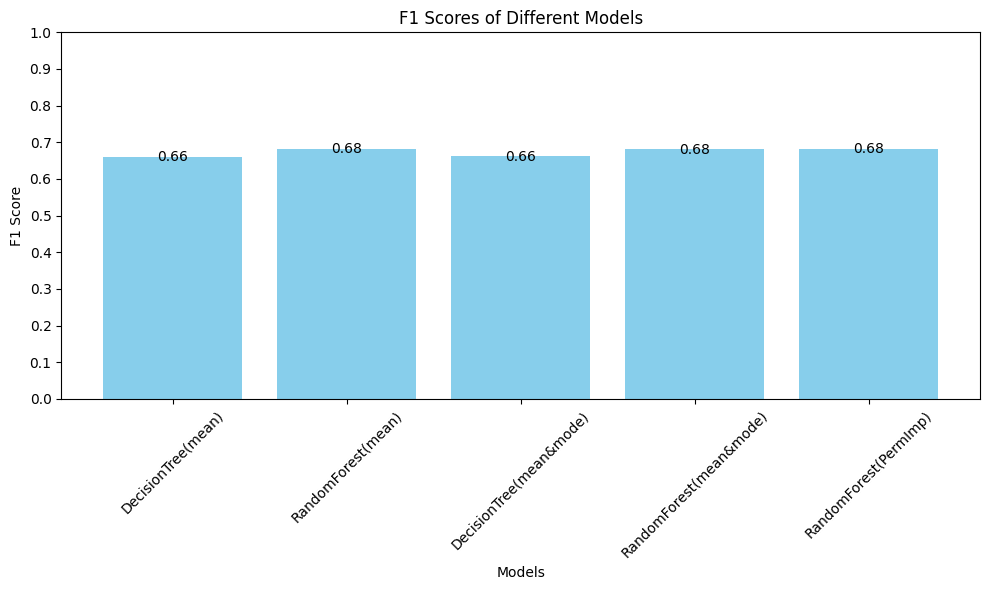

In [ ]:
import matplotlib.pyplot as plt

# F1 scores for different models
model_names = ['DecisionTree(mean)', 'RandomForest(mean)', 'DecisionTree(mean&mode)', 'RandomForest(mean&mode)', 'RandomForest(PermImp)']
f1_scores = [f1_score_dt1, f1_score_rf1, f1_score_dt2, f1_score_rf2, f1_score_PI]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, f1_scores, color='skyblue')

# Labels
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('F1 Scores of Different Models')
plt.ylim(0.5, 1)  # Setting the y-axis limit from 0.5 to 1
plt.yticks([i/10 for i in range(11)])  # Setting y-axis ticks with an increment of 0.1
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability

# Adding value labels on top of each bar
for bar, f1_score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.02, round(f1_score, 2), ha='center', va='bottom', color='black')

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()



Based on the above plot, RandomForest(mean),RandomForest(mean&mode) and RandomForest(Permimp) models have high F1 score(i.e, 0.68). Let's evaluate other performance metrics for these 3 models to determine the best performing model.

1. RandomForest(mean)

In [ ]:
from pyspark.sql.types import DoubleType

# Cast the prediction and target columns to DoubleType to ensure data consistency and compatibility
predictions_rf1 = predictions_rf1.withColumn("prediction_rf1", predictions_rf1["prediction"].cast(DoubleType()))\
                          .withColumn("Target", predictions_rf1["Target"].cast(DoubleType()))

# Create an RDD of (prediction, label) pairs for MulticlassMetrics
predictionAndLabels = predictions_rf1.select("prediction_rf1", "Target").rdd.map(lambda row: (float(row["prediction_rf1"]), float(row["Target"])))

# Initialize MulticlassMetrics object with the prediction and label pairs
metrics = MulticlassMetrics(predictionAndLabels)

# Calculate the F1 scores for class 0 and class 1
f1_score_class_0 = metrics.fMeasure(0.0, beta=1.0)
f1_score_class_1 = metrics.fMeasure(1.0, beta=1.0)

# Count the number of instances for each class
count_0 = predictions_rf1.filter(predictions_rf1["Target"] == 0).count()
count_1 = predictions_rf1.filter(predictions_rf1["Target"] == 1).count()

# Calculate the total count of instances
total_count = predictions_rf1.count()

# Calculate the weighted F1 score using the counts and F1 scores of each class
weighted_f1 = ((count_0 * f1_score_class_0) + (count_1 * f1_score_class_1)) / total_count

In [ ]:
#Confusion Matrix
predictions_rf1.groupBy('Target').pivot('Prediction_rf1').count().show()

+------+---+---+
|Target|0.0|1.0|
+------+---+---+
|   0.0| 80| 95|
|   1.0| 25|200|
+------+---+---+



In [ ]:
#Performance Metrics - Precision, Recall, Weighted F1 score

rf1_model = bestModel_rf1.stages[-1]
rf1_metrics = rf1_model.evaluate(predictions_rf1.select("Target","continuous_scaled"))

print(f"Model Precision 0 : {rf1_metrics.precisionByLabel[0]}")
print(f"Model Recall 0 : {rf1_metrics.recallByLabel[0]}")
print(f"Model F1 0 : {rf1_metrics.fMeasureByLabel()[0]}")

print(f"Model Precision 1 : {rf1_metrics.precisionByLabel[1]}")
print(f"Model Recall 1 : {rf1_metrics.recallByLabel[1]}")
print(f"Model F1 1 : {rf1_metrics.fMeasureByLabel()[1]}")

#Calculated weighted F1 score
print("Weighted F1 Score: ", weighted_f1)

Model Precision 0 : 0.7619047619047619
Model Recall 0 : 0.45714285714285713
Model F1 0 : 0.5714285714285714
Model Precision 1 : 0.6779661016949152
Model Recall 1 : 0.8888888888888888
Model F1 1 : 0.7692307692307693
Weighted F1 Score:  0.6826923076923077


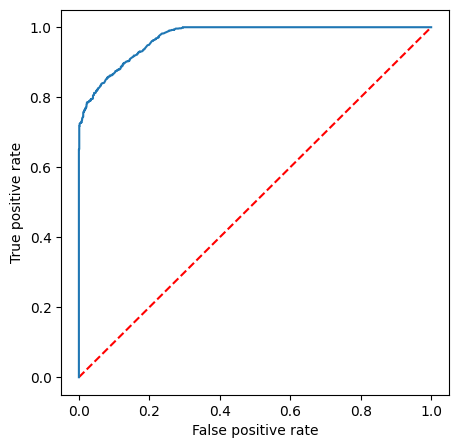

Area under ROC = 0.764685714285715 


In [ ]:
# ROC Curve
# The red dashed line represents the baseline (random) ROC curve
plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], "r--")  # Plotting the baseline ROC curve
plt.plot(
    rf1_model.summary.roc.select("FPR").collect(),  # FPR values
    rf1_model.summary.roc.select("TPR").collect(),  # TPR values
)
plt.xlabel("False positive rate")  # Label for x-axis
plt.ylabel("True positive rate")  # Label for y-axis
plt.show()  # Display the ROC curve plot

# Area Under Curve
# Evaluate the area under the ROC curve using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(
    labelCol="Target",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC",
)
accuracy = evaluator.evaluate(predictions_rf1)
print(f"Area under ROC = {accuracy} ")  # Print the area under the ROC curve



RandomForest(mean&mode)

In [ ]:

# Cast the prediction and target columns to DoubleType to ensure data consistency and compatibility
predictions_rf2 = predictions_rf2.withColumn("prediction_rf2", predictions_rf2["prediction"].cast(DoubleType()))\
                          .withColumn("Target", predictions_rf2["Target"].cast(DoubleType()))

# Create an RDD of (prediction, label) pairs for MulticlassMetrics
predictionAndLabels = predictions_rf2.select("prediction_rf2", "Target").rdd.map(lambda row: (float(row["prediction_rf2"]), float(row["Target"])))

# Initialize MulticlassMetrics object with the prediction and label pairs
metrics = MulticlassMetrics(predictionAndLabels)

# Calculate the F1 scores for class 0 and class 1
f1_score_class_0 = metrics.fMeasure(0.0, beta=1.0)
f1_score_class_1 = metrics.fMeasure(1.0, beta=1.0)

# Count the number of instances for each class
count_0 = predictions_rf2.filter(predictions_rf2["Target"] == 0).count()
count_1 = predictions_rf2.filter(predictions_rf2["Target"] == 1).count()

# Calculate the total count of instances
total_count = predictions_rf2.count()

# Calculate the weighted F1 score using the counts and F1 scores of each class
weighted_f1 = ((count_0 * f1_score_class_0) + (count_1 * f1_score_class_1)) / total_count

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
# Confusion Matrix
predictions_rf2.groupBy('Target').pivot('Prediction_rf2').count().show()

+------+---+---+
|Target|0.0|1.0|
+------+---+---+
|   0.0| 83| 92|
|   1.0| 30|195|
+------+---+---+



In [ ]:
#Performance Metrics - Precision, Recall, Weighted F1 score

rf2_model = bestModel_rf2.stages[-1]
rf2_metrics = rf2_model.evaluate(predictions_rf2.select("Target","scaled_features"))

print(f"Model Precision 0 : {rf2_metrics.precisionByLabel[0]}")
print(f"Model Recall 0 : {rf2_metrics.recallByLabel[0]}")
print(f"Model F1 0 : {rf2_metrics.fMeasureByLabel()[0]}")

print(f"Model Precision 1 : {rf2_metrics.precisionByLabel[1]}")
print(f"Model Recall 1 : {rf2_metrics.recallByLabel[1]}")
print(f"Model F1 1 : {rf2_metrics.fMeasureByLabel()[1]}")

#Calculated weighted F1 score
print("Weighted F1 Score: ", weighted_f1)

Model Precision 0 : 0.7345132743362832
Model Recall 0 : 0.4742857142857143
Model F1 0 : 0.576388888888889
Model Precision 1 : 0.6794425087108014
Model Recall 1 : 0.8666666666666667
Model F1 1 : 0.7617187500000001
Weighted F1 Score:  0.680636935763889


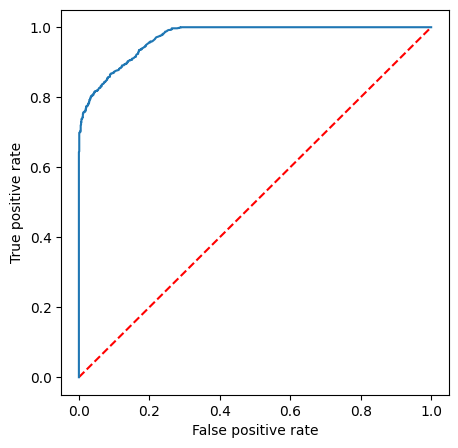

Area under ROC = 0.7643809523809532 


In [ ]:
# Plotting the ROC Curve
plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], "r--")  # Diagonal line representing random guessing
plt.plot(
    rf2_model.summary.roc.select("FPR").collect(),
    rf2_model.summary.roc.select("TPR").collect(),
)  # Plotting the ROC curve using the false positive rate (FPR) and true positive rate (TPR)
plt.xlabel("False positive rate")  # Label for the x-axis
plt.ylabel("True positive rate")   # Label for the y-axis
plt.show()

# Calculating Area Under the ROC Curve (AUC)
evaluator = BinaryClassificationEvaluator(labelCol="Target", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
accuracy = evaluator.evaluate(predictions_rf2)
print(f"Area under ROC = {accuracy} ")  # Printing the AUC value

RandomForest(Permutation Importance)

In [ ]:
# Cast the prediction and target columns to DoubleType explicitly
predictions_PI = predictions_PI.withColumn("prediction_PI", predictions_PI["prediction"].cast(DoubleType()))\
                          .withColumn("Target", predictions_PI["Target"].cast(DoubleType()))

# Create an RDD of (prediction, label) pairs for MulticlassMetrics
predictionAndLabels = predictions_PI.select("prediction_PI", "Target").rdd.map(lambda row: (float(row["prediction_PI"]), float(row["Target"])))

# Initialize MulticlassMetrics object with the prediction and label pairs
metrics = MulticlassMetrics(predictionAndLabels)

# Calculate the F1 scores for class 0 and class 1
f1_score_class_0 = metrics.fMeasure(0.0, beta=1.0)
f1_score_class_1 = metrics.fMeasure(1.0, beta=1.0)

# Count the number of instances for each class
count_0 = predictions_PI.filter(predictions_PI["Target"] == 0).count()
count_1 = predictions_PI.filter(predictions_PI["Target"] == 1).count()

# Calculate the total count of instances
total_count = predictions_PI.count()

# Calculate the weighted F1 score using the counts and F1 scores of each class
weighted_f1 = ((count_0 * f1_score_class_0) + (count_1 * f1_score_class_1)) / total_count

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
#Confusion Matrix
predictions_PI.groupBy('Target').pivot('Prediction_PI').count().show()

+------+---+---+
|Target|0.0|1.0|
+------+---+---+
|   0.0| 80| 95|
|   1.0| 25|200|
+------+---+---+



In [ ]:
#Performance Metrics - Precision, Recall, Weighted F1 score

PI_model = bestModel_PI.stages[-1]
PI_metrics = PI_model.evaluate(predictions_PI.select("Target","continuous_scaled"))

print(f"Model Precision 0 : {PI_metrics.precisionByLabel[0]}")
print(f"Model Recall 0 : {PI_metrics.recallByLabel[0]}")
print(f"Model F1 0 : {PI_metrics.fMeasureByLabel()[0]}")

print(f"Model Precision 1 : {PI_metrics.precisionByLabel[1]}")
print(f"Model Recall 1 : {PI_metrics.recallByLabel[1]}")
print(f"Model F1 1 : {PI_metrics.fMeasureByLabel()[1]}")

#Calculated weighted F1 score
print("Weighted F1 Score: ", weighted_f1)

Model Precision 0 : 0.7619047619047619
Model Recall 0 : 0.45714285714285713
Model F1 0 : 0.5714285714285714
Model Precision 1 : 0.6779661016949152
Model Recall 1 : 0.8888888888888888
Model F1 1 : 0.7692307692307693
Weighted F1 Score:  0.6826923076923077


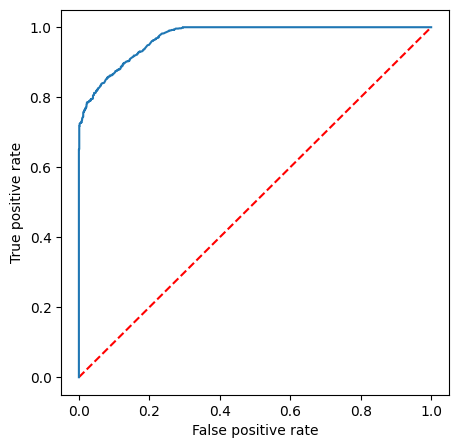

Area under ROC = 0.764685714285715 


In [ ]:
#ROC Curve
plt.figure(figsize=(5, 5))  # Set the figure size
plt.plot([0, 1], [0, 1], "r--")  # Plot the diagonal line
plt.plot(
    PI_model.summary.roc.select("FPR").collect(),  # Plot the false positive rate
    PI_model.summary.roc.select("TPR").collect(),  # Plot the true positive rate
)
plt.xlabel("False positive rate")  # Set x-axis label
plt.ylabel("True positive rate")  # Set y-axis label
plt.show()  # Display the plot

#Area Under Curve
evaluator = BinaryClassificationEvaluator(  # Initialize the BinaryClassificationEvaluator
    labelCol="Target",  # Set the label column
    rawPredictionCol="rawPrediction",  # Set the raw prediction column
    metricName="areaUnderROC",  # Set the metric name to calculate AUC
)
accuracy = evaluator.evaluate(predictions_rf1)  # Calculate the area under the ROC curve
print(f"Area under ROC = {accuracy} ")  # Print the AUC value

#**5.Discussion/Conclusion**

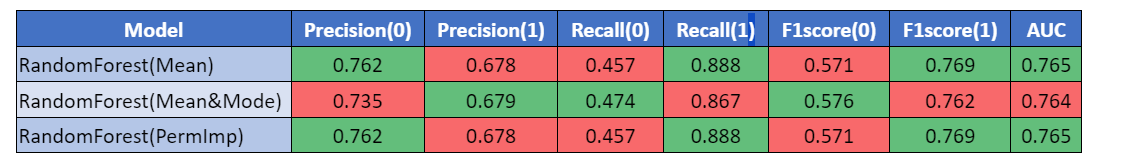

After considering all the above performance metrics, i concluded the following points.

* Initially, when I looked at precision and recall for all three models, I found consistent values. However, there was a clear difference in precision and recall between classes 0 and 1. This wasn't surprising given the class imbalance in the target variable, as shown in our EDA plot. With class 1 being more dominant, the models tended to predict instances as 1 more often due to the dataset's inherent skew.
* All three models have an AUC of around 0.76, which is considered good. This means the models are better at predicting true positives before false positives. However, since they all have similar AUC values, we can't rely on this metric alone to determine the best model.
* Looking at the weighted F1 scores, RandomForest with mean imputation and permutation importance showed the highest values (0.68). While not perfect, this F1 score is the best I achieved across various modeling techniques. However, it could have been better if we had addressed missing data differently (analysing the missing pattern and  eliminating the rows with more missing values, however according to given guidelines we are not suppose to eliminate any rows), as imputation may have reduced data quality and affected predictions.
* After evaluating all performance metrics, I concluded that RandomForest with features identified using Permutation Importance (rf_PI) is the best model. Even though RandomForest with mean imputation performed similarly, the rf_PI model simplifies things by using fewer variables and reducing model complexity.Therefore, **Random Forest with features identified using Permutation Importance(rf_PI) is the best model**.
* My EDA revealed that features like 'E' and 'C' could significantly impact target predictions, which was further supported by permutation importance analysis. This suggests that these marketing features are crucial for predicting whether the crypto price will increase after 2 weeks.
* Despite the potential impact of Event type (TR_3_EventInd) and search trends (index_3) on the target, I excluded them from further analysis due to poor data quality, mainly because of a high number of missing values.

Through my modeling techniques, I improved the model performance from 0.61(Baseline Model) to 0.683.

To conclude, Random Forest with less features(lower model complexity) with weighted f1-score of 0.68 is identified as the best. It includes all the significant market features which can influenc the price change of crypto currency.



